In [528]:
import os
import sys
import urllib, io
os.getcwd()
sys.path.append("..")
# sys.path.append("../utils")
sys.path.append("../../stimuli")


import numpy as np
import scipy.stats as stats
import pandas as pd

import pymongo as pm
from collections import Counter
from functools import reduce
import json
import re
import ast

from PIL import Image, ImageOps, ImageDraw, ImageFont 

from io import BytesIO
import base64

import  matplotlib
from matplotlib import pylab, mlab, pyplot
%matplotlib inline
from IPython.core.pylabtools import figsize, getfigs
plt = pyplot
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42

import seaborn as sns
sns.set_context('talk')
sns.set_style('darkgrid')

from IPython.display import clear_output

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", message="numpy.dtype size changed")
warnings.filterwarnings("ignore", message="numpy.ufunc size changed")

import drawing_utils as drawing
import importlib
import scoring

import blockworld_helpers as utils

In [130]:
## directory & file hierarchy
proj_dir = os.path.abspath('..')
datavol_dir = os.path.join(proj_dir,'data')
analysis_dir =  os.path.abspath('.')
results_dir = os.path.join(proj_dir,'results')
plot_dir = os.path.join(results_dir,'plots')
csv_dir = os.path.join(results_dir,'csv')
json_dir = os.path.join(results_dir,'json')
exp_dir = os.path.abspath(os.path.join(proj_dir,'behavioral_experiments'))
png_dir = os.path.abspath(os.path.join(datavol_dir,'png'))

## add helpers to python path
if os.path.join(proj_dir,'stimuli') not in sys.path:
    sys.path.append(os.path.join(proj_dir,'stimuli'))
    
if not os.path.exists(results_dir):
    os.makedirs(results_dir)
    
if not os.path.exists(plot_dir):
    os.makedirs(plot_dir)   
    
if not os.path.exists(csv_dir):
    os.makedirs(csv_dir)       

In [465]:
# experiment_name = 'prior_elicitation_lax_tower_4_block_unique_silhouettes_procedural'
# iteration_name = 'pilot-prolific-0'

experiment_name = 'prior_elicitation_lax_tower_4_block_unique_silhouettes_categorization'
iteration_name = 'prolific-pilot-0'

In [466]:
# set vars 
auth = pd.read_csv(os.path.join(analysis_dir,'../auth.txt'), header = None) # this auth.txt file contains the password for the sketchloop user
pswd = auth.values[0][0]
user = 'sketchloop'
host = 'cogtoolslab.org'

# have to fix this to be able to analyze from local
import pymongo as pm
conn = pm.MongoClient('mongodb://sketchloop:' + pswd + '@127.0.0.1')

db = conn['lax']
coll = db[experiment_name]

# ## look up number of trials (including paired-practice)
expected_trials = 26

In [467]:
# really_run = False;

# if really_run:
#     db.drop_collection(experiment_name)

In [473]:
df_all = pd.DataFrame(coll.find({'iterationName': iteration_name}))
# all_data[['gameID','trial_index','label']]

In [474]:
# # Find people who have completed all trials
# query = coll.find({"$and":[
#                         {'trialType':'normal-trial'},
#                         {'eventType':'trialEnd'},
#                         {'iterationName': { '$in': [iteration_name] }},
#                         {'trialNum': numTrials-1}]
#                      })

# complete_data_df = pd.DataFrame(query.sort('absoluteTime'))
# complete_data_ids = list(complete_data_df['gameID'])
# print(str(len(complete_data_ids)) + ' participants found')


# pd.DataFrame(coll.find({'iterationName': iteration_name}))

## Filter out metadata

Info about stimulus set downloaded from mongo.
Contains info about tower type.

In [475]:
df_meta = df_all[(df_all.datatype == 'stim_metadata') &
            (df_all.iterationName == iteration_name)]\
        [["gameID","partitionFamily","splitNumber","stimNumbers", "stimGroups",
          "numGames","experimentType","experimentName", "s3_bucket", "versionInd"]]

In [476]:
df_meta

,gameID,partitionFamily,splitNumber,stimNumbers,stimGroups,numGames,experimentType,experimentName,s3_bucket,versionInd
0,9196-c8bee20e-3ada-4a5d-8f91-bfd1e920f5cd,0.0,0.0,"[000, 007, 009, 011, 019, 023, 025, 029, 034, ...","{'100': 'tall', '106': 'neither', '113': 'neit...",0.0,prior_elicitation,ca_prior_elicitation_4_block_unique_silhouette...,lax-tower-4-block-unique-silhouettes-json,0.0
1,1811-420df5be-1b49-44f9-a99a-b13e65f3e26b,0.0,1.0,"[002, 003, 012, 013, 024, 026, 035, 038, 040, ...","{'101': 'tall', '108': 'neither', '110': 'neit...",0.0,prior_elicitation,ca_prior_elicitation_4_block_unique_silhouette...,lax-tower-4-block-unique-silhouettes-json,0.0
23,8055-487bb17a-4420-4748-ad97-47f238440fc4,0.0,2.0,"[001, 004, 010, 015, 030, 037, 039, 042, 043, ...","{'102': 'tall', '103': 'neither', '109': 'tall...",0.0,prior_elicitation,ca_prior_elicitation_4_block_unique_silhouette...,lax-tower-4-block-unique-silhouettes-json,0.0


## Grab trial data

In [477]:
df_trial = df_all[(df_all.datatype == 'trial_end') &
             (df_all.trial_type == 'stimuli-language-production') &
             (df_all.iterationName == iteration_name)]\
            [['datatype', 'iterationName', 'condition',
       'config_name', 'workerID', 'gameID', 'shuffle', 'trialOrder', 'rt',
       'url', 'trial_type', 'trial_index', 'time_elapsed', 'internal_node_id',
       'view_history', 'label', 'stimId', 'stimURL', 'responses']]

### Add metadata to trial data

In [478]:
# verify stim groups in metadata are correct
dicts = list(df_all[df_all.datatype=='stim_metadata']['stimGroups'])

stim_groups = reduce(lambda dict1, dict2: {**dict1, **dict2}, dicts)
pd.Series(list(stim_groups.values())).value_counts()

# assign stim groups from metadata (althoug)
df_trial['stim_group'] = df_trial['stimId'].apply(lambda stim: stim_groups[stim])
df_trial = df_trial.merge(df_meta, how='left', on='gameID')

## Todo: get complete data sets

In [479]:
df_trial.groupby('gameID')['trial_index'].last()

gameID
1811-420df5be-1b49-44f9-a99a-b13e65f3e26b     5.0
8055-487bb17a-4420-4748-ad97-47f238440fc4    27.0
9196-c8bee20e-3ada-4a5d-8f91-bfd1e920f5cd    26.0
Name: trial_index, dtype: float64

## Which metadata need re-running?

In [480]:
# todo: 
# get each gameID + their partitionFamily splitNumber stimNumbers, 
# get number of trials


# todo: work out which batches need to be re-run

In [481]:
df_trial

,datatype,iterationName,condition,config_name,workerID,gameID,shuffle,trialOrder,rt,url,...,stim_group,partitionFamily,splitNumber,stimNumbers,stimGroups,numGames,experimentType,experimentName,s3_bucket,versionInd
0,trial_end,prolific-pilot-0,all,lax-tower-4-block-unique-silhouettes-categoriz...,5e18f899bd51071c9d98cfe0,9196-c8bee20e-3ada-4a5d-8f91-bfd1e920f5cd,NaN,NaN,35918.300,NaN,...,neither,0.0,0.0,"[000, 007, 009, 011, 019, 023, 025, 029, 034, ...","{'100': 'tall', '106': 'neither', '113': 'neit...",0.0,prior_elicitation,ca_prior_elicitation_4_block_unique_silhouette...,lax-tower-4-block-unique-silhouettes-json,0.0
1,trial_end,prolific-pilot-0,all,lax-tower-4-block-unique-silhouettes-categoriz...,5e18f899bd51071c9d98cfe0,9196-c8bee20e-3ada-4a5d-8f91-bfd1e920f5cd,NaN,NaN,49057.900,NaN,...,wide,0.0,0.0,"[000, 007, 009, 011, 019, 023, 025, 029, 034, ...","{'100': 'tall', '106': 'neither', '113': 'neit...",0.0,prior_elicitation,ca_prior_elicitation_4_block_unique_silhouette...,lax-tower-4-block-unique-silhouettes-json,0.0
2,trial_end,prolific-pilot-0,all,lax-tower-4-block-unique-silhouettes-categoriz...,5e18f899bd51071c9d98cfe0,9196-c8bee20e-3ada-4a5d-8f91-bfd1e920f5cd,NaN,NaN,37599.700,NaN,...,neither,0.0,0.0,"[000, 007, 009, 011, 019, 023, 025, 029, 034, ...","{'100': 'tall', '106': 'neither', '113': 'neit...",0.0,prior_elicitation,ca_prior_elicitation_4_block_unique_silhouette...,lax-tower-4-block-unique-silhouettes-json,0.0
3,trial_end,prolific-pilot-0,all,lax-tower-4-block-unique-silhouettes-categoriz...,5e18f899bd51071c9d98cfe0,9196-c8bee20e-3ada-4a5d-8f91-bfd1e920f5cd,NaN,NaN,46734.500,NaN,...,neither,0.0,0.0,"[000, 007, 009, 011, 019, 023, 025, 029, 034, ...","{'100': 'tall', '106': 'neither', '113': 'neit...",0.0,prior_elicitation,ca_prior_elicitation_4_block_unique_silhouette...,lax-tower-4-block-unique-silhouettes-json,0.0
4,trial_end,prolific-pilot-0,all,lax-tower-4-block-unique-silhouettes-categoriz...,5e18f899bd51071c9d98cfe0,9196-c8bee20e-3ada-4a5d-8f91-bfd1e920f5cd,NaN,NaN,57035.600,NaN,...,wide,0.0,0.0,"[000, 007, 009, 011, 019, 023, 025, 029, 034, ...","{'100': 'tall', '106': 'neither', '113': 'neit...",0.0,prior_elicitation,ca_prior_elicitation_4_block_unique_silhouette...,lax-tower-4-block-unique-silhouettes-json,0.0
5,trial_end,prolific-pilot-0,all,lax-tower-4-block-unique-silhouettes-categoriz...,5e18f899bd51071c9d98cfe0,9196-c8bee20e-3ada-4a5d-8f91-bfd1e920f5cd,NaN,NaN,110427.300,NaN,...,neither,0.0,0.0,"[000, 007, 009, 011, 019, 023, 025, 029, 034, ...","{'100': 'tall', '106': 'neither', '113': 'neit...",0.0,prior_elicitation,ca_prior_elicitation_4_block_unique_silhouette...,lax-tower-4-block-unique-silhouettes-json,0.0
6,trial_end,prolific-pilot-0,all,lax-tower-4-block-unique-silhouettes-categoriz...,60ff47ff139f434f93f7050f,1811-420df5be-1b49-44f9-a99a-b13e65f3e26b,NaN,NaN,224978.970,NaN,...,neither,0.0,1.0,"[002, 003, 012, 013, 024, 026, 035, 038, 040, ...","{'101': 'tall', '108': 'neither', '110': 'neit...",0.0,prior_elicitation,ca_prior_elicitation_4_block_unique_silhouette...,lax-tower-4-block-unique-silhouettes-json,0.0
7,trial_end,prolific-pilot-0,all,lax-tower-4-block-unique-silhouettes-categoriz...,5e18f899bd51071c9d98cfe0,9196-c8bee20e-3ada-4a5d-8f91-bfd1e920f5cd,NaN,NaN,64099.400,NaN,...,neither,0.0,0.0,"[000, 007, 009, 011, 019, 023, 025, 029, 034, ...","{'100': 'tall', '106': 'neither', '113': 'neit...",0.0,prior_elicitation,ca_prior_elicitation_4_block_unique_silhouette...,lax-tower-4-block-unique-silhouettes-json,0.0
8,trial_end,prolific-pilot-0,all,lax-tower-4-block-unique-silhouettes-categoriz...,5e18f899bd51071c9d98cfe0,9196-c8bee20e-3ada-4a5d-8f91-bfd1e920f5cd,NaN,NaN,39125.700,NaN,...,neither,0.0,0.0,"[000, 007, 009, 011, 019, 023, 025, 029, 034, ...","{'100': 'tall', '106': 'neither', '113': 'neit...",0.0,prior_elicitation,ca_prior_elicitation_4_block_unique_silhouette...,lax-tower-4-block-unique-silhouettes-json,0.0
9,trial_end,prolific-pilot-0,all,lax-tower-4-block-unique-silhou

## Data preprocessing

In [482]:
df_trial.groupby('stimId').first()['label']

stimId
000    2 red vertical rectangles on the ends and 2 bl...
001    blue z, red on left side coming down from top ...
002    2 sideways blue boxes stair stepped against tw...
004    2 vertical red rectangles with 1 horizonal blu...
007    2 horizontal blue rectangles next to 2 red ver...
009    one blue horizontal rectangle on top and 2 red...
010    kinda like a hebrew letter taf. blue horizonta...
011    one blue horizontal rectangle to the right, be...
013    A 'U' shape, made of two up and down red recta...
015    slouching llama variation. vertical red rectan...
019    2 blue rectangles one on top and one on the bo...
023    2 blue horizontal rectangles on top next to ea...
025    2 horizontal blue rectangles on top next to ea...
029    one red vertical rectangle on top and below it...
030    2 horixontal blue rectangles making an s, 1 ve...
034    one blue horizontal rectangle to the right bel...
037    blue z, one red top center, one red coming up ...
039    2 blue horizontal

## Basic plots to test data

  - Make some simple plots
	- Description length over trial num
	- For each tower:
		- display responses
		- variance in desc length
		- mean desc length

In [555]:
# setup
block_dims = [(2,1),(1,2)]
block_colors = ['#0A2FB3','#B32F0A']
black = ['#000000','#000000'] # used to display silhouettes
grey = ['#333333','#333333']
world_width = 8
world_height = 8
world_center = int((world_width-1)/2)

In [484]:
towers = pd.read_pickle("../../stimuli/tower_4_block_unique_silhouettes/tower_4_block_unique_silhouettes.pkl")

In [ ]:
utils.draw_world

In [510]:
towers_with_labels = df_trial[['stimId','label','gameID']].groupby('stimId')
tower_ids = towers_with_labels.first().reset_index()['stimId']

In [552]:
list(towers_with_labels.get_group('000')['label'])

['2 red vertical rectangles on the ends and 2 blue horizontal rectangles in the middle']

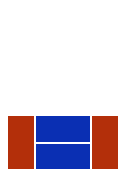

000
['2 red vertical rectangles on the ends and 2 blue horizontal rectangles in the middle']


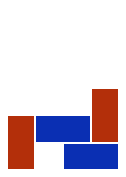

001
['blue z, red on left side coming down from top side, red on right coming up from shelf']


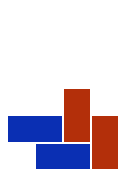

002
['2 sideways blue boxes stair stepped against two up and down red rectangle boxes']


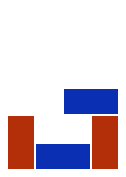

004
['2 vertical red rectangles with 1 horizonal blue rectangle between them on the bottom and another horizontal blue rectangle on top of the right red one']


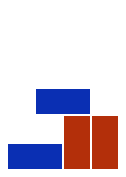

007
['2 horizontal blue rectangles next to 2 red vertical rectangles']


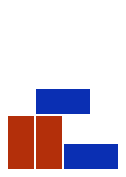

009
['one blue horizontal rectangle on top and 2 red verticle rectangles to the left next to each other then a blue horizontal rectangle on the bottom right of the red ones']


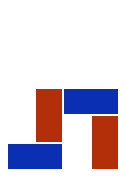

010
['kinda like a hebrew letter taf. blue horizontal, red vertical coming up from the right side, blue horizontal touching top right side of red, another red coming down from the bottom right of the blue']


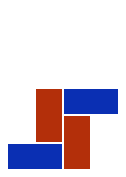

011
['one blue horizontal rectangle to the right, below it to the left a red vertical rectangle to the right and top a red vertical rectangle then a blue one below and to the left']


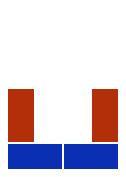

013
["A 'U' shape, made of two up and down red rectangles sitting on top of the ends of two sideways blue rectangles"]


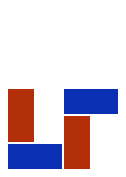

015
['slouching llama variation. vertical red rectanngle, horizontal blue underneath and to the right. red vertical coming up from the right side of the blue. horizontal blue on top of the red pointing right']


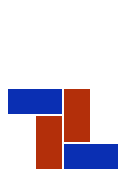

019
['2 blue rectangles one on top and one on the bottom 2 red rectangles vertical in between the blue ones\n']


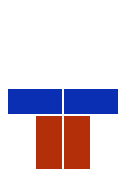

023
['2 blue horizontal rectangles on top next to each other then 2 red vertical rectangles on the bottom like feet']


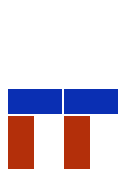

025
['2 horizontal blue rectangles on top next to each other and 2 red vertical rectangles on the bottom like feet']


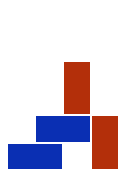

029
['one red vertical rectangle on top and below it a blue horizontal rectangle then next to it on the right a red vertical rectangle.  then a blue horizontal rectangle below the other blue one and staggered to the left']


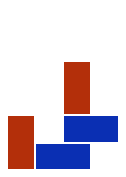

030
['2 horixontal blue rectangles making an s, 1 vertical red on the right side, one vertical red coming up from the center of the s']


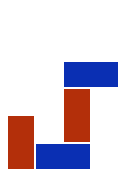

034
['one blue horizontal rectangle to the right below it a red vertical rectangle below that a blue horizontal rectangle facing left and next to the blue one a red horizontal rectangle which is left']


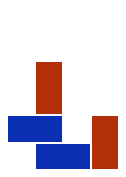

037
['blue z, one red top center, one red coming up from bottom right']


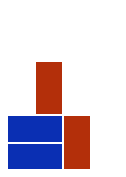

039
['2 blue horizontal rectangles stacked in a square. one red vertical rectangle on top of the right side, one vertical red rectangle aligned with the right side']


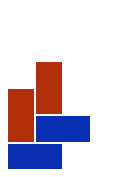

041
['2 red vertical rectangles next to each other like a chart and 2 blue horizontal rectangles on the bottom of the red ones also staggered like bricks']


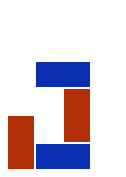

042
['2 blue horizontal rectangles with a red veritcal rectangle in between on the right. red vertical rectangle coming up from the side of the bottom blue']


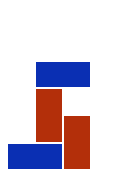

043
['blue pointing right, red under left side, blue pointing left, red coming up from right side of bottom blue']


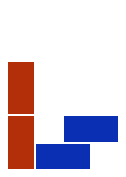

049
['2 red vertical rectangles on the left on top of each other and 2 blue horizontal rectangles staggered on the bottom red one']


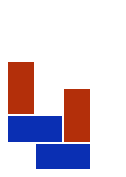

053
['one red vertical rectangle on top to the left below that a blue horizontal rectangle and below it staggered to the right another blue horizontal rectangle and on the right on top of the bottom blue one a red vertical rectangle']


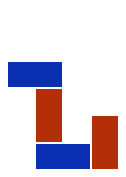

054
['kinda looks like a llama. horizonal blue rectangle on the top, vertical red rectangle coming down from the right side, horizonal blue underneath the red on the right, red vertical coming up from the right side of the blue']


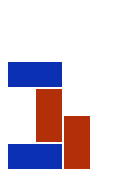

055
['horiontal blue rectangle, vertical red coming down from bottom right, horizontal blue same as top one but on the bottom. red vertical coming up from right side of bottom blue']


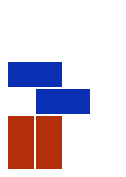

059
['blue z, red square on bottom left of z']


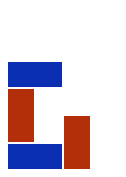

060
['one blue rectangle horizontal on top a red verticle rectangle below it to the left then a blue horizontal rectangle ont he bottom and then a red vertical rectangle to the right bottom']


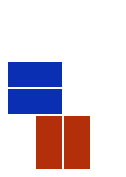

061
['2 blue squares on top horizontally and 2 red vertical squares on the bottom']


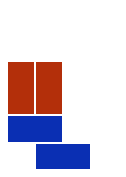

062
['2 red vertical rectangles next to each other, below it a blue horizontal rectangle and below that another blue horizontal rectangle but more to the right']


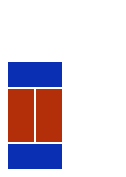

063
['two red vertical rectangles next to each other to make a square. blue horizontal rectangles like the sandwich bread on top and bottom']


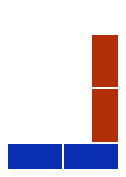

064
['2 horizontal blue rectangles in a line, 2 vertical red rectangles coming up from the right side of the blue line']


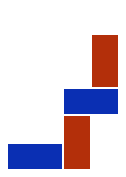

065
['one red vertical rectangle on top to the right, below that a blue horizontal one, below that a red vertical one to the left, then next to that a blue horizontal rectangle']


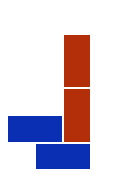

067
['blue z, 2 red in a line coming up from bottom z shelf']


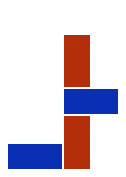

068
['one red vertical rectangle standing on top, below that a blue horizontal rectangle, below that a red vertical rectangle and next to that on the left a blue horizontal rectangle']


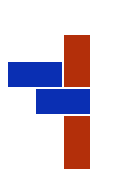

070
['Two up and down red rectangles with the right end of a blue sideways rectangle between their ends, and another blue sideways rectangle stacked on the left end of the first blue rectangle']


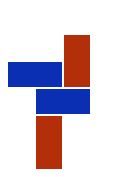

071
['2 horizontal blue rectangles in a z shape, 2 vertical red rectangles, one to the top right of the z, the other centered underneath the z']


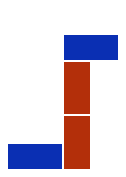

072
['one blue horizontal rectangle on top to the right and below it 2 red vertical rectangles, then on the bottom to the left one blue horizontal rectangle']


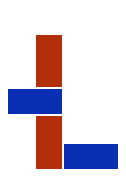

075
['top to bottom, red vertical, blue horizontal pointing left, red vertical in line with the top one, blue horizontal pointing right coming from the side of the bottom red']


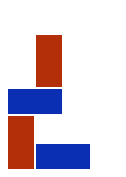

076
['1 red vertical rectangle to the right, then below it a blue horizontal rectangle then to the left a red vertical rectangle and in the bottom right a blue horizontal rectangle']


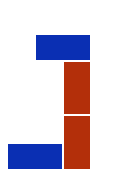

077
['Two red rectangle boxes stacked long ways up and down, with a blue sideways rectangle box on the top, and a blue sideways rectangle box on the side even with the bottom']


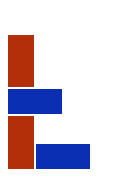

081
['one red vertical triangle on top to the left, below that a blue horizontal rectangle below that a red vertical rectangle lined up with other red one and then to the right of the last red one a blue horizontal rectangle']


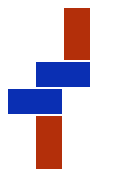

088
['2 blue horizontal rectangles in an s shape. 2 red vertical rectangles, one coming up from the top right of the s, the other coming down from the center of the s']


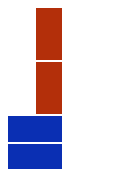

092
['2 horizontal blue rectangles stacked to make a square. 2 vertical red rectangles stacked in a line up from the right side of the square']


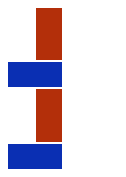

097
['vertical red, horizontal blue underneath pointing left,  vertical red in line, horizontal blue under pointing left']


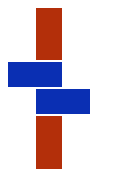

099
['2 blue horizontal rectangles in a z shape. 2 vertical red rectangles centered on top and bottom']


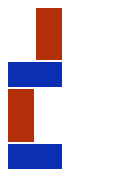

100
['one red vertical rectangle on top standing, then one blue horizontal rectangle below it, then a red vertical rectangle below that then a blue horizontal rectangle on the bottom']


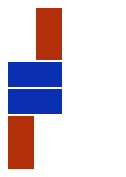

102
['2 blue horizontal rectangles stacked in a square in the center, red vertical rectancles coming up from top right and down from bottom left']


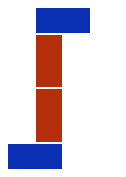

103
['long boi. s shape with blue horizontal on top, two stacked red vertical in coming down from bottom left, blue horizontal pointing left on the bottom']


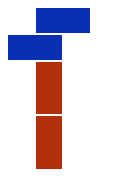

106
['2 blue horizontal rectangles stacked on top of each but one left and one right, then below that 2 red vertical rectangles stacked below each other']


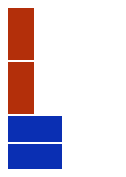

109
['2 horizontal blue rectangles stacked on top of each other to make a square. 2 vertical red rectangles stacked in a line coming up from the left side of the square']


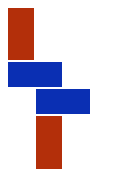

113
['2 red vertical rectangles one on top and one on the bottom 2 blue horizontal rectangles in the middle staggered']


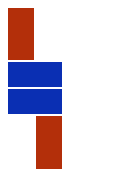

115
['one red vertical rectangle to the left and then 2 blue horizontal rectangle below then one red vertical rectangle to the right']


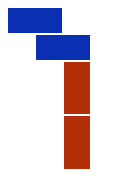

123
['2 blue horizontal in a z, two ref vertical stacked on top in a line coming down from bottom right side of z']


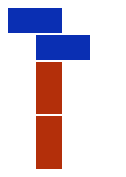

124
['blue z, 2 red stacked in line coming down from center']


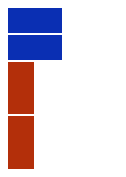

129
['2 blue horizontal rectangles stacked\n2 red vertical rectangles stacked']


In [557]:
for towerId in tower_ids:
    utils.draw_tower(utils.worldify(list(towers[towers.tower_number_str == towerId]['stim'])[0],
                                    block_dims = block_dims, 
                                    block_colors = block_colors))
    print(towerId)
    print(list(towers_with_labels.get_group(towerId)['label']))

In [516]:
towers[towers.tower_number_str == towerId]

,silhouette_str,index,blocks_above_ground,fully_connected,fully_connected_diag,n_blocks,silhouette,stim,stim_tuple,tower_height,tower_width,two_h_two_v,tower_number,tower_number_str,tower_name,group
0,0000000000000000000000000000000000000000000000...,1385,1,True,True,4,"[[0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, ...","[{'x': 0, 'y': 0, 'height': 2, 'width': 1}, {'...","((0, 0, 2, 1), (1, 0, 1, 2), (3, 0, 2, 1), (1,...",2,4,True,0,000,tower_4_block_unique_silhouette_000,neither
1,0000000000000000000000000000000000000000000100...,1249,2,True,True,4,"[[0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, ...","[{'x': 0, 'y': 0, 'height': 2, 'width': 1}, {'...","((0, 0, 2, 1), (2, 0, 1, 2), (1, 1, 1, 2), (3,...",3,4,True,1,001,tower_4_block_unique_silhouette_001,wide
2,0000000000000000000000000000000000000000001000...,791,2,True,True,4,"[[0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, ...","[{'x': 1, 'y': 0, 'height': 1, 'width': 2}, {'...","((1, 0, 1, 2), (3, 0, 2, 1), (0, 1, 1, 2), (2,...",3,4,True,2,002,tower_4_block_unique_silhouette_002,wide
3,0000000000000000000000000000000000000000001100...,1362,1,True,True,4,"[[0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, ...","[{'x': 0, 'y': 0, 'height': 1, 'width': 2}, {'...","((0, 0, 1, 2), (2, 0, 2, 1), (3, 0, 2, 1), (2,...",3,4,True,3,003,tower_4_block_unique_silhouette_003,neither
4,0000000000000000000000000000000000000000001100...,605,1,True,True,4,"[[0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, ...","[{'x': 0, 'y': 0, 'height': 2, 'width': 1}, {'...","((0, 0, 2, 1), (1, 0, 1, 2), (3, 0, 2, 1), (2,...",3,4,True,4,004,tower_4_block_unique_silhouette_004,neither
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125,0000000000000000110000001000000010000000100000...,308,3,True,True,4,"[[0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, ...","[{'x': 0, 'y': 0, 'height': 1, 'width': 2}, {'...","((0, 0, 1, 2), (0, 1, 2, 1), (0, 3, 2, 1), (0,...",6,2,True,125,125,tower_4_block_unique_silhouette_125,tall
126,0000000000000000110000001000000010000000110000...,1336,3,True,True,4,"[[0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, ...","[{'x': 1, 'y': 0, 'height': 2, 'width': 1}, {'...","((1, 0, 2, 1), (0, 2, 1, 2), (0, 3, 2, 1), (0,...",6,2,True,126,126,tower_4_block_unique_silhouette_126,tall
127,0000000000000000110000001000000010000000110000...,696,3,True,True,4,"[[0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, ...","[{'x': 0, 'y': 0, 'height': 2, 'width': 1}, {'...","((0, 0, 2, 1), (0, 2, 1, 2), (0, 3, 2, 1), (0,...",6,2,True,127,127,tower_4_block_unique_silhouette_127,tall
128,0000000000000000110000001100000001000000010000...,1072,3,True,True,4,"[[0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, ...","[{'x': 1, 'y': 0, 'height': 2, 'width': 1}, {'...","((1, 0, 2, 1), (1, 2, 2, 1), (0, 4, 1, 2), (0,...",6,2,True,128,128,tower_4_block_unique_silhouette_128,tall


In [498]:
def print_tower(group):
    stimId = group['stimId'][0]
    print(towers[tower_number_str == stimId][0])

In [ ]:
utils.